In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as skio
import skimage.transform as sktr
import torch as to
import torchvision as tovi
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
class Data(Dataset) :
    
    def __init__(self):
        
        super(Data,self).__init__()
        
        self.data = pd.read_csv("../../data/trainMNIST.csv").values
        self.label = pd.read_csv("../../data/trainMNISTlabels.csv").values
    
    
    def __getitem__(self, inx) :
        
        sample = self.data[inx]
        label = self.label[inx]
        
        img = np.reshape(sample,(1,28,28))
        
        img = to.tensor(img, dtype=to.float32)
        label = to.tensor(label, dtype=to.float32)
        
        return img, label
        
    
    def __len__(self):
        
        return len(self.data)

architecture :

$$1\times28\times28 \xrightarrow{\text{conv:} k_5,s_1}  16 \times 24 \times24 \xrightarrow{\text{maxp:} k_2,s_2} 16\times12\times12 \xrightarrow{\text{conv:}k_3,s_1} 16\times10\times10 \xrightarrow{\text{maxp:}k_2,s_2} 16\times5\times5$$

In [11]:
class Model(nn.Module):
    
    def __init__(self):
        
        super(Model,self).__init__()
            
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)  
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        
        self.linear1 = nn.Linear(400,128)
        self.linear2 = nn.Linear(128,32)
        self.linear3 = nn.Linear(32,3)
        
        
    def encoder(self,inp):

        
        out = self.conv1(inp)
        out = F.relu(out)
        out, self.inx1 = self.pool(out)

        
        out = self.conv2(out)
        out = F.relu(out)
        out, self.inx2 = self.pool(out)           

        
        out = out.view(-1,400)
        
        out = F.relu(self.linear1(out))  

        out = F.relu(self.linear2(out))
      
        out = self.linear3(out)

        
        
        return out
        
               
    def decoder(self,inp):
    
        self.copy_conv1 = to.tensor(self.conv1.weight, requires_grad=False)
        self.copy_conv2 = to.tensor(self.conv2.weight, requires_grad=False)
        
        self.copy_linear1 = to.tensor(self.linear1.weight, requires_grad=False)
        self.copy_linear2 = to.tensor(self.linear2.weight, requires_grad=False)
        self.copy_linear3 = to.tensor(self.linear3.weight, requires_grad=False)

    
        out = F.relu(F.linear(inp,self.copy_linear3.t()))
      
        out = F.relu(F.linear(out,self.copy_linear2.t()))
    
        out = F.relu(F.linear(out,self.copy_linear1.t()))

        
        out = out.view(-1,16,5,5)

        
        out = F.max_unpool2d(out, self.inx2, kernel_size=2, stride=2)
        out = F.conv_transpose2d(out, self.copy_conv2 )
        out = F.relu(out)

        
        out = F.max_unpool2d(out, self.inx1, kernel_size=2, stride=2)
        out = F.conv_transpose2d(out, self.copy_conv1 )

        
        out = F.tanh(out)

        
        return out
        
        
    
    def forward(self,inp):
        
        out = self.encoder(inp)
        out = self.decoder(out)

        
        return out
    
    


In [4]:
    def evaluate(self,inp):
        
        chk = to.tensor([1],dtype=to.float32)
        
        if type(inp) != type(chk):
            
            # inp = np.transpose(inp, (2,1,0) ) #for images
            inp = to.tensor(inp, dtype=to.float32, device="cuda")
            
        out = forward(inp)
        
        return out

In [12]:
model = Model().cuda()

In [6]:
train_data = Data()
data_loader = DataLoader(train_data,batch_size=32, shuffle=True)

label : tensor([4.])


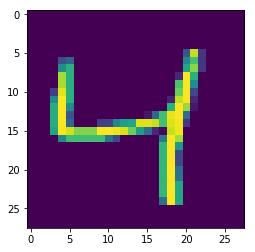

In [7]:
sample, lbl = train_data[1]

print("label :", lbl)

img = sample.detach().cpu().numpy()
plt.imshow(img[0])

In [13]:
epoch = 100
lr = 0.001
Criterion = nn.MSELoss()
Optimizer = to.optim.Adam(model.parameters(), lr=lr)

In [14]:
counter = []
loss_history = [] 
iteration_number= 0

In [15]:
for i in range(epoch):
    
    for data in data_loader :
        
        img, lbl = data
        
        out = model(img.cuda())
        loss = Criterion(out,img.cuda())
        
        
        Optimizer.zero_grad()
        loss.backward()
        Optimizer.step()
        
    print("Epoch number {}\n  Current loss {}\n".format(i,loss.item()))
    counter.append(epoch)
    loss_history.append(loss.item())
        

/usr/local/anaconda35/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch number 0
  Current loss 7483.4140625

Epoch number 1
  Current loss 7007.9248046875

Epoch number 2
  Current loss 6778.3876953125

Epoch number 3
  Current loss 7483.6220703125

Epoch number 4
  Current loss 7222.8544921875

Epoch number 5
  Current loss 7389.27587890625

Epoch number 6
  Current loss 7281.0830078125

Epoch number 7
  Current loss 6800.44775390625

Epoch number 8
  Current loss 6975.4306640625

Epoch number 9
  Current loss 7582.298828125

Epoch number 10
  Current loss 7397.66943359375

Epoch number 11
  Current loss 7742.94287109375

Epoch number 12
  Current loss 7293.806640625

Epoch number 13
  Current loss 7937.61572265625

Epoch number 14
  Current loss 7454.0498046875

Epoch number 15
  Current loss 6187.62744140625

Epoch number 16
  Current loss 6761.02587890625

Epoch number 17
  Current loss 6565.7314453125

Epoch number 18
  Current loss 6726.19287109375

Epoch number 19
  Current loss 6841.55029296875

Epoch number 20
  Current loss 7345.6337890625

In [16]:
len(loss_history)

100

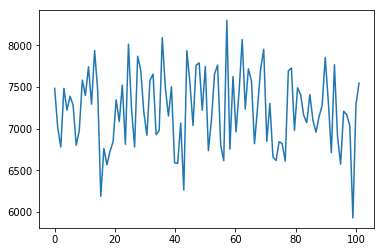

In [18]:
plt.plot(np.linspace(0,101,num=100),loss_history)

In [19]:
to.save(model.state_dict(),"./autoencoder_linear")

In [ ]:
sample, lbl = train_data[10]

print("label :", lbl)

with to.no_grad() :
    out = model(sample.view(1,1,28,28))

img = out.detach().numpy()
plt.imshow(img[0][0])